<a href="https://colab.research.google.com/github/finlaycm/tensorflow_tumor_detection/blob/master/part_1_tumors_and_patches_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
colab_root_dir = '/content'
drive_dir='/content/drive'
project_root_dir = os.path.join(drive_dir,'My Drive','deeplearning','cancer_classification')
tumor_dir = os.path.join(project_root_dir,'tumors')
data_dir = os.path.join(project_root_dir,'data')
drive.mount(drive_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help in OH if you're stuck.

### Reminder

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), or use all the available data. 


In [ ]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 5 not upgraded.
Need to get 92.5 kB of archives.
After t

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2 as cv
import json
import pathlib
import random
import pandas as pd
import time
import shutil
from time import gmtime, strftime
import sklearn
import time 
import matplotlib.image as mpimg
import random

import xml.etree.ElementTree as et 


In [ ]:
def read_slide(slide_path, level, x = 0, y = 0, width=None, height=None, as_float=False, show=False):
    slide = open_slide(slide_path)
    if not width: width=slide.level_dimensions[level][0]
    if not height: height=slide.level_dimensions[level][1]
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    if '_mask.tif' in str(slide_path):
      im = im[:,:,0]
    if show:
      plt.imshow(im)
      plt.show()
    return im

In [ ]:
slide_dir=os.path.join(project_root_dir,'myslides')
slide_files = [os.path.join(slide_dir,s) for s in os.listdir(slide_dir)]
mask_dir=os.path.join(project_root_dir,'mymasks')
mask_files = [os.path.join(mask_dir,m) for m in os.listdir(mask_dir)]
xml_dir=os.path.join(project_root_dir,'myannotations')
xml_files = [os.path.join(xml_dir,x) for x in os.listdir(xml_dir)]



In [ ]:
slide1 = slide_files[0]
w, h =open_slide(str(slide1)).level_dimensions[0]

tumor_091


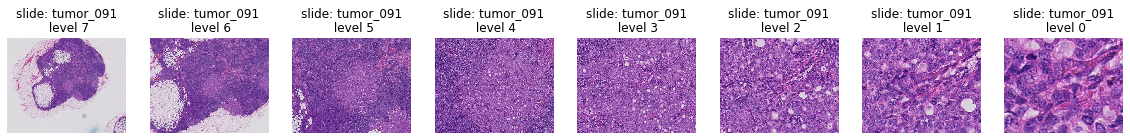

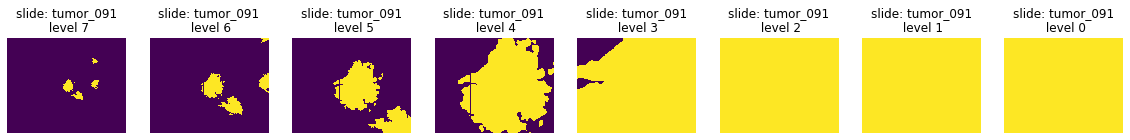

In [ ]:
slide_path= [s for s in slide_files if 'tumor_091' in s][0]
slide_title = pathlib.Path(slide_path).stem
mask_path =[m for m in mask_files if slide_title in m][0]
print(slide_title)
w, h =open_slide(slide_path).level_dimensions[0]
epsx, epsy = w//9, w//6
w, h = w - epsx, h - epsy
x, y = 0, 0
fig,axs = plt.subplots(nrows=1,ncols=8,figsize=(20,3))
for l in range(7,-1,-1):
  lw = w//2**(7)
  lh = h//2**(7)
  x =w//2+epsx-lw*2**l//2
  y = h//2+epsy - lh*2**l//2
  title='slide: {}\n level {}'.format(slide_title,l)
  im = read_slide(slide_path,l, x, y, lw, lh)
  axs[7-l].set_title(title)
  axs[7-l].imshow(im)
  axs[7-l].axis('off')
fig,axs = plt.subplots(nrows=1,ncols=8,figsize=(20,3))
for l in range(7,-1,-1):
  lw = w//2**(7)
  lh = h//2**(7)
  x =w//2+epsx - lw*2**l//2
  y = h//2+epsy - lh*2**l//2
  title='slide: {}\n level {}'.format(slide_title,l)
  im = read_slide(mask_path,l, x, y, lw, lh)
  if im.sum()==im.shape[0]*im.shape[1]:
    im_copy=im.copy()
    im_copy[0][0]=0
    im=im_copy
  if im.sum()==0:im[0][0]=1
  axs[7-l].set_title(title)
  axs[7-l].imshow(im)
  axs[7-l].axis('off')

In [ ]:
# tumors_in = pd.read_pickle(os.path.join(project_root_dir,'tumors_df.pkl'))
# tumors_in.groupby('slide_name')['tumor_name'].nunique(), tumors_in.iloc[np.argmax(tumors_in['positive_pixel_count'])]

In [ ]:
tumor_dir = os.path.join(project_root_dir,'tumors')
os.makedirs(tumor_dir,exist_ok=True)
len(os.listdir(tumor_dir))



362

In [ ]:
###make dir 'tumors' is it does not exist to save tumor masks

xml_root = [[f, et.parse(f).getroot()]  for f in xml_files]
tumors= []
for xml_file, root in xml_root:
  slide_name = pathlib.Path(xml_file).stem
  slide_path = [s for s in slide_files if slide_name in s][0]
  mask_path = os.path.join(mask_dir,slide_name+'_mask.tif')
  tumors_len = len([node for node in root[0]])
  for t in range(tumors_len):
    PartOfGroup = root[0][t].attrib.get("PartOfGroup")
    if PartOfGroup == '_0':
      tumor_name = '{}_{}'.format(slide_name,t)
      tumor_mask_path= os.path.join(project_root_dir,'tumors',tumor_name+'_mask.jpg')
      c=sum([1  for p in root[0][t][0]])
      tpixels=[(int(float(p.attrib.get("X"))),int(float(p.attrib.get("Y"))))  for p in root[0][t][0]]
      x = min([int(float(p.attrib.get("X")))  for p in root[0][t][0]])//256*256
      w = (max([int(float(p.attrib.get("X")))  for p in root[0][t][0]]) + 256)//256*256 - x
      y = min([int(float(p.attrib.get("Y"))) for p in root[0][t][0]])//256*256
      h = (max([int(float(p.attrib.get("Y"))) for p in root[0][t][0]]) + 256)//256*256 - y
      tumor = [slide_path,mask_path,slide_name,tumor_mask_path,tumor_name,int(x),int(y),int(w),int(h),c,tpixels]
      #print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
      tumors.append(tumor)
      level = 3
      w = w//2**level
      h = h//2**level
      tumor_image = read_slide(mask_path, level, x,y,w,h)
      Image.fromarray(tumor_image*255).save(tumor_mask_path)  


In [ ]:
# ###Tumor dataset
tumor_columns= ['slide_path','mask_path','slide_name','tumor_mask_path','tumor_name','x','y','width','height','positive_pixel_count','tumor_pixels']
tumor_rows = [{'slide_path':t[0],'mask_path':t[1],'slide_name':t[2]
               ,'tumor_mask_path':t[3],'tumor_name':t[4],'x':t[5],'y':t[6],'width':t[7],'height':t[8], 'positive_pixel_count': t[9],'tumor_pixels': t[10]} for t in tumors]
tumors_df = pd.DataFrame(tumor_rows, columns = tumor_columns)
tumors_df.to_pickle(os.path.join(project_root_dir,'tumors_df.pkl'))
tumors_df.head()
tumors_total = tumors_df.shape[0]
slide_total = len(tumors_df.slide_path.unique())
## slides_num_tumors lists slide name and number of tumors
slides_num_tumors = [(s.split('/')[-1], tumors_df[tumors_df.slide_path==s].shape[0]) for s in tumors_df.slide_path.unique()]
slides_num_tumors
tumors_df.head(5)


,slide_path,mask_path,slide_name,tumor_mask_path,tumor_name,x,y,width,height,positive_pixel_count,tumor_pixels
0,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101_0,20224,13824,13568,5120,523,"[(33626, 15050), (33568, 15084), (33469, 15064..."
1,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101_1,36352,41984,3840,3328,191,"[(37584, 43334), (37639, 43287), (37709, 43272..."
2,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101_2,48128,23040,3072,2048,111,"[(48615, 23300), (48538, 23296), (48462, 23294..."
3,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101_3,39168,18944,6144,12544,714,"[(41439, 19438), (41471, 19493), (41518, 19536..."
4,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101,/content/drive/My Drive/deeplearning/cancer_cl...,tumor_101_4,94464,12800,13312,5120,803,"[(107718, 13998), (107749, 14048), (107750, 14..."


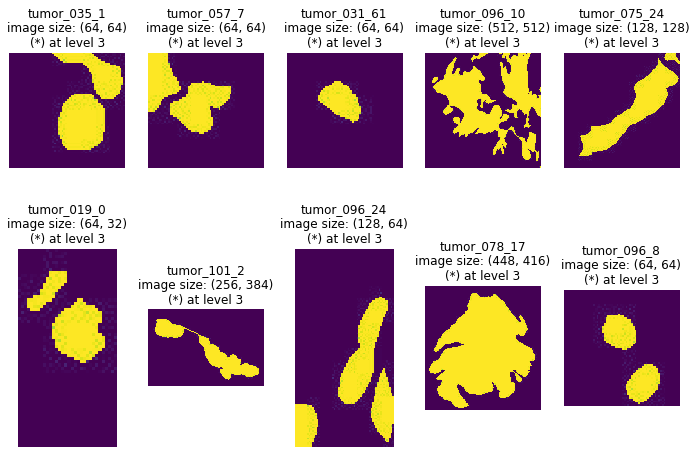

In [ ]:
###Show tumors with Size
tumor_jpgs = [t for t in tumors_df['tumor_mask_path'] if 'tumor_038' not in t]
sample_tumor_jpgs = random.sample(tumor_jpgs,10)
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(12,8))
for i in range(len(sample_tumor_jpgs)):
  img=mpimg.imread(sample_tumor_jpgs[i])
  title='{}\nimage size: {}\n(*) at level 3'.format(pathlib.Path(sample_tumor_jpgs[i])
                  .stem.replace('_mask',''),img.shape)
  axs[i//5][i%5].set_title(title)
  axs[i//5][i%5].imshow(img)
  axs[i//5][i%5].axis('off')
  if i == 0: a = img

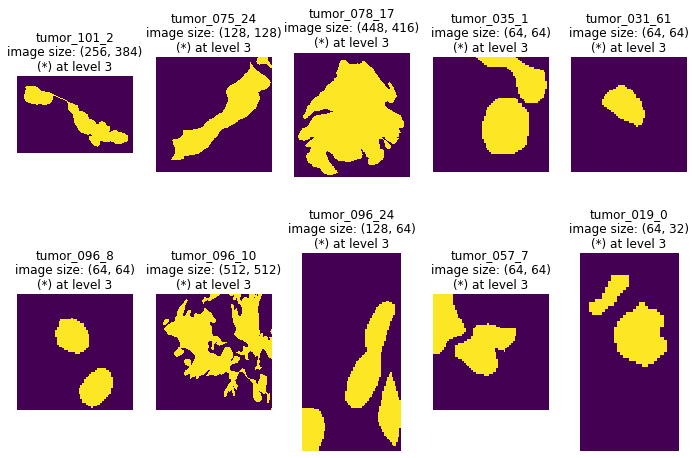

In [ ]:
sample_tumors = tumors_df[tumors_df['tumor_mask_path'].isin(sample_tumor_jpgs)][['mask_path','tumor_name','x','y','width','height']]
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(12,8))
i = 0
for r, c in sample_tumors.iterrows():
  mask_path,tumor_name,x,y,w,h = c
  level = 3
  img=read_slide(mask_path,level,x,y,w//2**level,h//2**level)
  title='{}\nimage size: {}\n(*) at level 3'.format(tumor_name,img.shape)
  axs[i//5][i%5].set_title(title)
  axs[i//5][i%5].imshow(img)
  axs[i//5][i%5].axis('off')  
  i += 1



In [ ]:
####TRY creating patches_df in one shot
###took two hours, not very efficient
start_time = time.time()
now = time.strftime("%H:%M", time.localtime(start_time))
print("Start Time {} ".format(now)) 
patches = []
level = 0
i = 0

for slide_path,mask_path,slide_name,tumor_mask_path,tumor_name, x, y, w, h, c, tpixels in tumors:
  for xpatch in range(x,x+w,256):
    for ypatch in range(y,y+h,256):
      if (slide_path in [str(s) for s in slide_files] ) & (mask_path in [str(s) for s in mask_files]):
        #pos_pixels = number of positive pixels in 256 X 256 patch
        pos_pixels = read_slide(mask_path, level, xpatch,ypatch,256,256).sum()
        label = 'negative' if pos_pixels == 0 else 'positive'
        patches.append({'slide_path':slide_path,'mask_path':mask_path,'slide_name':slide_name
                        ,'tumor_name':tumor_name,'patch_name':'{}_{}'.format(tumor_name,i),'x':xpatch,'y':ypatch
                        ,'width':256,'height':256, 'pos_pixels':pos_pixels, 'label':label})
        i +=1
end_time = time.time()
now = time.strftime("%H:%M", time.localtime(end_time))
print("End Time {} ".format(now)) 
print("--- %s seconds ---" % (end_time - start_time))
df_columns= ['slide_path','mask_path','slide_name','tumor_name','patch_name','x','y'
                        ,'width','height', 'pos_pixels','label']
patches_df2 = pd.DataFrame(patches, columns = df_columns)



Start Time 07:19 
End Time 08:22 
--- 3765.2062163352966 seconds ---


In [ ]:
patches_df2 = pd.read_pickle(os.path.join(project_root_dir,'patches_df2.pkl'))

In [ ]:
### ASSIGN train test val sets randomly
###Create directories to store
#patches_df2['patch_name']=patches_df2['patch_name'].apply(lambda x: pathlib.Path(x).name.replace('_mask.jpg',''))
_ = [os.makedirs(os.path.join(project_root_dir,'data',set,label)
        , exist_ok=True) for set in ['train','test','val'] for label in ['positive','negative']]

nrows=patches_df2.shape[0]
nrows
set_values = [a for a,f in zip(['train','test','val'], [nrows-10000,5000,5000]) for _ in range(f)]
random.shuffle(set_values)
patches_df2['set']=set_values
###assign path to patch randomply
patches_df2['patch_path'] = patches_df2[['set','label','patch_name']].apply(lambda x: os.path.join(project_root_dir,'data',x[0],x[1],x[2]+'.jpg'), axis=1)
patches_df2 = patches_df2[patches_df2['slide_path'].isin([str(m) for m in slide_files])]
patches_df2.to_pickle(os.path.join(project_root_dir,'patches_df2.pkl'))


In [ ]:
patches_df2[['set','label','patch_name']].apply(lambda x: os.path.join(project_root_dir,'data',x[0],x[1],x[2]+'.jpg'), axis=1)

NameError: ignored

In [ ]:
patches_df2.shape,patches_df2.loc[patches_df2['slide_name'].isin(test_slides)].shape

((93850, 13), (15192, 13))

In [ ]:
patches_df2.groupby('slide_name')['patch_name','tumor_name'].agg(lambda x: x.nunique())

,patch_name,tumor_name
slide_name,,
tumor_001,120,1
tumor_002,45,1
tumor_005,106,4
tumor_012,40,1
tumor_016,4431,7
tumor_019,4,3
tumor_023,109,6
tumor_031,6545,72
tumor_035,8,2


In [ ]:
patches_df2.groupby('slide_name')['patch_name'].count()

slide_name
tumor_001      120
tumor_002       45
tumor_005      106
tumor_012       40
tumor_016     4431
tumor_019        4
tumor_023      109
tumor_031     6545
tumor_035        8
tumor_057       91
tumor_059       20
tumor_064     4171
tumor_075     2579
tumor_078    34479
tumor_081       24
tumor_084     1258
tumor_091     1524
tumor_094     1602
tumor_096     1352
tumor_101     5026
tumor_110    30316
Name: patch_name, dtype: int64

In [ ]:
patches_df2 = pd.read_pickle(os.path.join(project_root_dir,'patches_df2.pkl'))
test_slides = ['tumor_094','tumor_096','tumor_019','tumor_016','tumor_031','tumor_084']
print('test set size', patches_df2.loc[patches_df2['slide_name'].isin(test_slides)].shape[0])
patches_df2.loc[patches_df2['slide_name'].isin(test_slides)
    ,'patch_path'] = patches_df2.loc[patches_df2['slide_name'].isin(test_slides)
    ,'patch_path'].apply(lambda x: x.replace(x.split('/')[7],'test'))
patches_df2.loc[patches_df2['slide_name'].isin(test_slides)
    ,'set']= 'test'
patches_df2.loc[~patches_df2['slide_name'].isin(test_slides)
    ,'set']= ''
patches_df2.sort_values(by='set',inplace=True)
patches_df2.reset_index(inplace=True, drop=True)
# patches_df2.loc[~patches_df2['slide_name'].isin(test_slides)
#     ,'slide_name'].shape
nrows = patches_df2.loc[~patches_df2['slide_name'].isin(test_slides)].shape[0]
trainnum,valnum = int(nrows*0.80),nrows-int(nrows*0.80)
set_values = [a for a,f in zip(['train','val'], [trainnum,valnum]) for _ in range(f)]
random.shuffle(set_values)
patches_df2.loc[~patches_df2['slide_name'].isin(test_slides),'set']=set_values
patches_df2['patch_path'] = patches_df2[['set','label','patch_name']].apply(lambda x: os.path.join(project_root_dir,'data',x[0],x[1],x[2]+'.jpg'), axis=1)
patches_df2.to_pickle(os.path.join(project_root_dir,'patches_df.pkl'))


test set size 15192


In [ ]:
patches_df2.shape

(93850, 13)

In [ ]:
sum(patches_df2[['label','patch_path']].apply(lambda x: x[0]==x[1].split('/')[8], axis = 1).astype(int))

93850

In [ ]:
# patches_df2.loc[patches_df2['slide_name'].isin(test_slides)
#     ,'patch_path'].unique()[0]
# patches_df2.loc[~patches_df2['slide_name'].isin(test_slides)
#     ,'set'].unique()
# patches_df2.sort_values(by='set',inplace=True)
patches_df2['set'].iloc[-15193:-15190]

78657        
78658    test
78659    test
Name: set, dtype: object

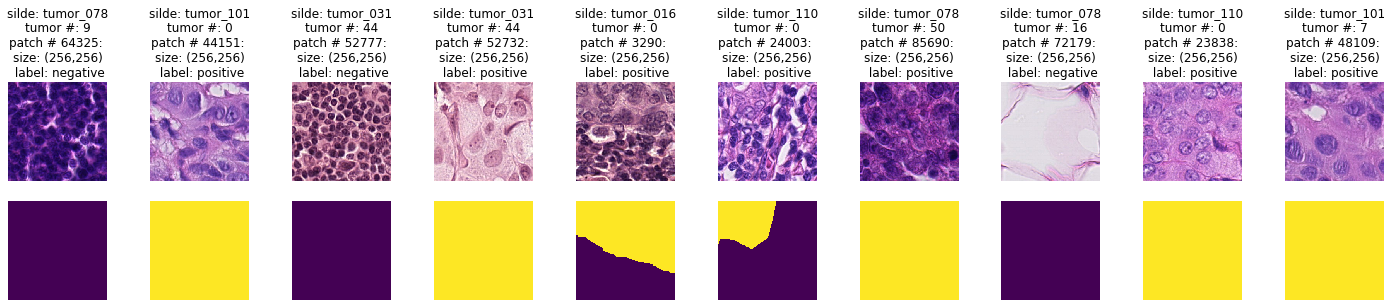

In [ ]:
### Print mask and patch at level 0
level = 0
i = 0
sample_patches = patches_df2[['slide_path','mask_path','x','y','label','pos_pixels','patch_name']].sample(n=10)
fig,axs = plt.subplots(nrows=2,ncols=10,figsize=(25,4))
for r,c in sample_patches.iterrows():
  slide_path,mask_path,x,y ,l, pos_pixels,patch_name= c
  mask=read_slide(mask_path,0,x,y,256,256)
  ###If the mask is only 1, the image will show blue color, to correct that, set one pixel to 0
  ###mask is not writable, I have to copy array and modify the copy
  m = mask.copy()
  if mask.sum()==65536:
    m[0,0]=0
  snum,tnum,pnum = patch_name.split('_')[1:]
  img=read_slide(slide_path,0,x,y,256,256)
  title='silde: tumor_{}\ntumor #: {}\npatch # {}: \nsize: (256,256)\n label: {}'.format(snum,tnum,pnum,l)
  axs[0][i].set_title(title)
  axs[0][i].imshow(img)
  axs[1][i].imshow(m)
  axs[0][i].axis('off')  
  axs[1][i].axis('off')
  a = (slide_path,mask)  
  i += 1

In [ ]:
patches_df2.shape
patches_df2[(patches_df2['label']=='negative') & (patches_df2['set']=='train')]['patch_path'].iloc[0]
patches_df2.groupby(['label','set']).size()

label     set  
negative  test      2104
          train    35618
          val       2108
positive  test      2896
          train    48232
          val       2892
dtype: int64

In [ ]:
patches_df2[patches_df2['label']=='positive'].shape


(54020, 13)

In [ ]:
test_slides = ['tumor_094','tumor_096','tumor_019','tumor_016']
patches_df2[patches_df2['slide_name'].isin(test_slides)].groupby('label')['patch_name'].count()

label
negative    2609
positive    4780
Name: patch_name, dtype: int64

In [ ]:
patch_paths = [p for p in pathlib.Path(data_dir).glob('*/*/*')]

OSError: ignored

In [ ]:
data_dir

'/content/drive/My Drive/deeplearning/cancer_classification/data'

In [1]:
for i in range(10):
  test_positive = os.listdir(os.path.join(data_dir,'test','positive'))[:500]
  test_negative = os.listdir(os.path.join(data_dir,'test','negative'))[:500]  
  train_positive = os.listdir(os.path.join(data_dir,'train','positive'))[:500]
  train_negative = os.listdir(os.path.join(data_dir,'train','negative'))[:500]
  val_positive = os.listdir(os.path.join(data_dir,'val','positive'))[:500]
  val_negative = os.listdir(os.path.join(data_dir,'val','negative'))[:500]  
  print(len(train_positive),len(train_negative))
  #print(len(val_positive),len(val_negative))
  #print(len(os.listdir(pos_dir)),len(os.listdir(neg_dir)))
  [os.rename(os.path.join(data_dir,'train','positive',f)
      ,os.path.join(data_dir,'allpatches','positive',f)) for f in train_positive]# if os.path.exists(f)]
  [os.rename(os.path.join(data_dir,'train','negative',f)
      ,os.path.join(data_dir,'allpatches','negative',f)) for f in train_negative]# if os.path.exists(f)]
  # [os.rename(os.path.join(data_dir,'val','positive',f)
  #     ,os.path.join(data_dir,'allpatches','positive',f)) for f in val_positive ]#if os.path.exists(f)]
  # [os.rename(os.path.join(data_dir,'val','negative',f)
  #     ,os.path.join(data_dir,'allpatches','negative',f)) for f in val_negative ]#if os.path.exists(f)]

In [ ]:
len(os.listdir(os.path.join(data_dir,'allpatches')))

In [ ]:
total_slides = len(patches_df2['slide_name'].unique())
total_tumors = len(patches_df2['tumor_name'].unique())
total_patches = len(patches_df2['patch_name'].unique())
min_num_tumors_in_slide=patches_df2.groupby('slide_name')['tumor_name'].nunique().min()
max_num_tumors_in_slide=patches_df2.groupby('slide_name')['tumor_name'].nunique().max()
total_positive_patches = patches_df2[patches_df2['label']=='positive'].shape[0]
total_negative_patches = patches_df2[patches_df2['label']=='negative'].shape[0]
print('Total number of slides: {}\n'
                'Total number of tumors: {}\n'
                'Total number of patches: {}\n'
                'Minimun number of tumors in slide: {}\n'
                'Maximun number of tumors in slide: {}\n'
                'Positive patches: {}\n'
                'Negative patches: {}\n'
                ''.format(total_slides
                        ,total_tumors
                        ,total_patches
                        ,min_num_tumors_in_slide
                        ,max_num_tumors_in_slide
                        , total_positive_patches
                        , total_negative_patches
                        ))
##[c['width']*c['height']//2**14 for r,c in tumors_df[['tumor_name','width','height']].iterrows()]

patches_df2.groupby(['slide_name','tumor_name']).size().reset_index(
    name='Total Patches').apply(lambda x: pd.Series([x[0],x[1].split('/')[-1].replace('_mask.jpg',''),x[2]],
    index=['slide_name','tumor_name','Total Patches']),axis=1).sort_values(
        'Total Patches', ascending= False).reset_index(drop=True)[:5]


slide_name
tumor_001     1
tumor_081     1
tumor_012     1
tumor_059     1
tumor_002     1
tumor_094     2
tumor_035     2
tumor_019     3
tumor_005     4
tumor_023     6
tumor_091     6
tumor_016     7
tumor_101     8
tumor_064    11
tumor_057    20
tumor_110    21
tumor_075    29
tumor_096    42
tumor_084    54
tumor_078    69
tumor_031    72
Name: tumor_name, dtype: int64
Total number of slides: 21
Total number of tumors: 361
Total number of patches: 93850
Minimun number of tumors in slide: 1
Maximun number of tumors in slide: 72
Positive patches: 54020
Negative patches: 39830



,slide_name,tumor_name,Total Patches
0,tumor_110,tumor_110_0,16170
1,tumor_078,tumor_078_16,12495
2,tumor_110,tumor_110_6,5456
3,tumor_031,tumor_031_44,4824
4,tumor_078,tumor_078_13,4648
